# PyTorch Tutorial / Quickstart
*author: Nikola Janjusevic*

Large overlap with [PyTorch's 60min Blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html?highlight=minute), tailored to image processing 
and building your own networks.

Overview:
- Define your **data**
- Construct your **network**
- **Train**, validate, test

## TENSORS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import glob              # easy file searching
from PIL import Image    # image loading
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv # data augmentation/loading utilities

In [ ]:
# can also wrap a numpy array
a = torch.tensor([0, 5])
b = torch.tensor([[1, 5],[2,10]])
# broadcasting over dim 0
c = a + b

In [ ]:
# show c
c

tensor([[ 1, 10],
        [ 2, 15]])

In [ ]:
c.requires_grad

False

In [ ]:
img = np.array(Image.open("/content/drive/MyDrive/CBSD432/100007.jpg").convert('L'))
print(img.shape)
print(img.min(), img.max())

(321, 481)
26 254


In [ ]:
imgt = torch.tensor(img).float() / 255.0
imgt.shape
print(imgt.min(), imgt.max())

tensor(0.1020) tensor(0.9961)


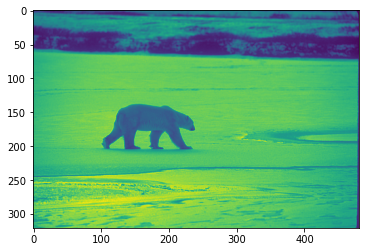

In [ ]:
plt.imshow(img)

## Example Problem: DeNoising

$$
y = x + v, \quad v \sim \mathcal{N}(0,\sigma I)
$$

Our noisy image $y$ is modeled as our ground-truth image $x$ that has been contaminated by additive Gaussian white noise (AWGN). 

In [ ]:
def awgn(x, sigma):
  return x + sigma*torch.randn_like(x)

torch.Size([321, 481])


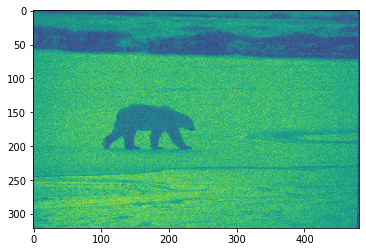

In [ ]:
y = awgn(imgt, 0.1)
print(y.shape)
plt.imshow(y)

## DEFINING A NETWORK

We're going to implement a Denoising neural network via the [Convolutional Dictionary Learning Network](https://nikopj.github.io/projects/dcdl/) (CDLNet) architecture. 


$$
\hat{x} = Dz^{(K)}
$$

$$
z^{(k+1)} =  \mathrm{ST}_{\tau^{(k)}}\left( z^{(k)} - A^{(k)}(B^{(k)}z^{(k)} - y)\right),\quad k=0,1,\dots,K-1
$$

$$
\mathrm{ST}_{\tau}(x) = \mathrm{sign}(x) \mathrm{ReLU}(\lvert x \rvert - \tau)
$$

where $k$ denotes the layer of the network, and $A,B,D$ are learned convolution operators.

In [ ]:
# soft-thresholding
def ST(x,t):
  return torch.sign(x)*F.relu(x.abs()-t)

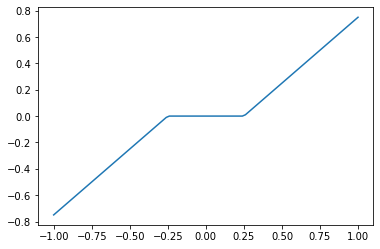

In [ ]:
x = torch.linspace(-1, 1, 101)
y = ST(x, 0.25)
plt.plot(x, y)

In [ ]:
x = torch.randn(5, requires_grad=True)
print(x)
y = ST(x,1)
print(y)
y.backward(gradient=torch.ones_like(x))
x.grad

tensor([-0.7498,  1.8391,  1.4107, -0.6198,  0.2420], requires_grad=True)
tensor([-0.0000, 0.8391, 0.4107, -0.0000, 0.0000], grad_fn=<MulBackward0>)


tensor([0., 1., 1., 0., 0.])

In [ ]:
class CDLNet(nn.Module):
  def __init__(self, K, nf, ks):
    # K: layers
    # nf: number of hidden features / subbands
    # ks: kernel-size (considering odd filter sizes only, for ease of same-padding)
    super().__init__()

    self.A = nn.ModuleList([nn.Conv2d(1, nf, ks, padding=(ks-1)//2, bias=False) for _ in range(K)])
    self.B = nn.ModuleList([nn.Conv2d(nf, 1, ks, padding=(ks-1)//2, bias=False) for _ in range(K)])
    self.D = nn.Conv2d(nf, 1, ks, padding=(ks-1)//2, bias=False)
    self.tau = nn.ParameterList([nn.Parameter(torch.zeros(1,nf,1,1)) for _ in range(K)])

    self.K = K
    self.nf = nf 
    self.ks = ks

  def forward(self, y):
    # pre-process input via mean-subtraction
    mu = y.mean(dim=(1,2), keepdim=True)
    y  = y - mu

    # initialize hidden state as zeros
    B, C, M, N = y.shape
    z = torch.zeros((B,self.nf,M,N), device=y.device)

    # run iterations
    for k in range(self.K):
      z = ST(z - self.A[k](self.B[k](z) - y), self.tau[k])
    
    # synthesize output from hidden state
    xhat = self.D(z)

    # post-process with mean-addition
    return xhat + mu 


In [ ]:
net = CDLNet(10, 8, 5)
imgt = torch.tensor(img, dtype=torch.float)[None,None,:,:] / 255
print(imgt.shape, imgt.dtype)

torch.Size([1, 1, 321, 481]) torch.float32


tensor(-0.2209, grad_fn=<MinBackward1>)

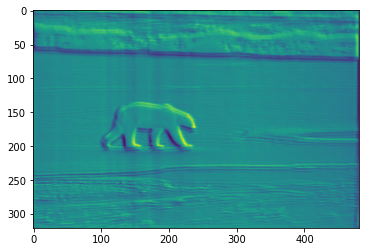

In [ ]:
out = net(imgt)
out.shape

plt.imshow(out[0,0].detach())
out.min()

In [ ]:
P = net.parameters()
for p in net.parameters():
  print(p.shape)

torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([8, 1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])
torch.Size([1, 8, 1, 1])


## DATASETS AND DATALOADERS

We're going to define our own dataset by overriding the base-class defined in PyTorch. See [the Dataset docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details.

We'll also use tools from TorchVision for augmenting the data. Further augmentation functions can be found in [the docs](https://pytorch.org/vision/stable/transforms.html).

In [ ]:

class MyImageFolder(torch.utils.data.Dataset):
  def __init__(self, root, crop_size):
    super().__init__()
    # get filenames
    self.files = glob.glob(root+"/*")

    # load grayscale images
    self.images = [Image.open(fn).convert('L') for fn in self.files]

    # define your transform
    self.transform = tv.transforms.Compose([tv.transforms.RandomCrop(crop_size), tv.transforms.ToTensor()])

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    return self.transform(self.images[i])

In [ ]:
ds = MyImageFolder("/content/drive/MyDrive/CBSD432", 64)

tensor(0.8196)

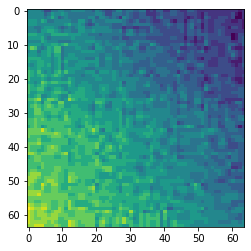

In [ ]:
out = ds[np.random.randint(len(ds))]
out.shape

plt.imshow(out[0])
out.max()

In [ ]:
# dataloader

dl = torch.utils.data.DataLoader(ds, batch_size=2, shuffle=True)

In [ ]:
# checkpointing

def save_ckpt(fn, network, optimizer):
  torch.save({'net': network.state_dict(), 'opt': opt.state_dict()}, fn)

def load_ckpt(fn, network, optimizer):
  ckpt = torch.load(fn)
  network.load_state_dict(ckpt['net'])
  optimizer.load_state_dict(ckpt['opt'])
  return network, optimizer

## TRAINING 

In [ ]:
from tqdm.autonotebook import tqdm
import time

SIGMA = 20/255 # noise-level

if torch.cuda.device_count() > 0:
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

avg_loss = 0
progress_bar = tqdm(dl)
for (i, batch) in enumerate(progress_bar):
  opt.zero_grad() # zero gradients to stop accumulation

  # create observation
  x = batch.to(device)
  y = x + SIGMA*torch.randn_like(x)

  # run forward pass
  xhat = net(y)

  # compute loss
  loss = torch.mean((x-xhat)**2)

  # run backward pass, update parameters
  loss.backward()
  opt.step()

  loss = loss.item()
  avg_loss += loss
  progress_bar.set_postfix_str(f"loss={loss:.3e}|avg_loss={avg_loss/(i+1):.3e}")

avg_loss /= i

print(f"AVERAGE LOSS = {avg_loss:.3e}")

  0%|          | 0/216 [00:00<?, ?it/s]

AVERAGE LOSS = 6.612e-03


In [ ]:
img = Image.open(ds.files[0]).convert('L')
imgt = tv.transforms.functional.to_tensor(img)
imgt.shape

torch.Size([1, 321, 481])

In [ ]:
x = imgt[None,...]
y = x + SIGMA*torch.randn_like(x)

xhat = net(y)

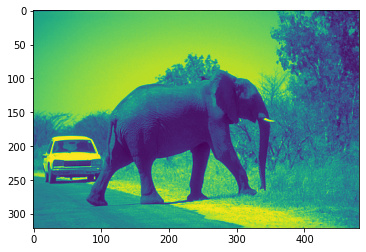

In [ ]:
plt.imshow(x[0,0])

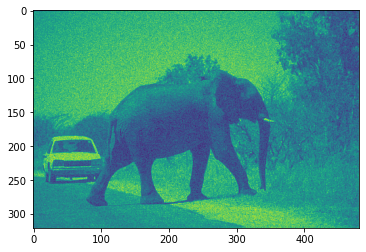

In [ ]:
plt.imshow(y[0,0])

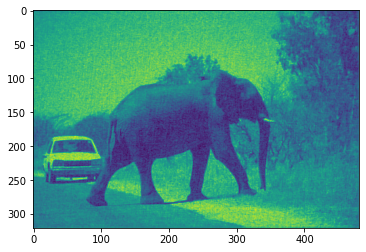

In [ ]:
plt.imshow(xhat[0,0].detach())

In [ ]:
def PSNR(x, xhat, maxval=1):
  return 20*np.log10(maxval) - 10*np.log10(torch.mean((x-xhat)**2))

In [ ]:
PSNR(x,xhat.detach())

tensor(26.2014)

Summary:
- Define your **data**
  - Dataset
  - data-augmentation (crops, flips)
  - dataloading (batchsize)
- Construct your **network**
  - parameters 
  - scale (larger/smaller versions)
  - forward pass
  - initialization
- **Train**, validate, test
  - initialize an optimizer with our network's parameters
  - zero gradients every minibatch
  - validate on separate data regularly
  - show statistics to make debugging easier for yourself (tqdm, etc.)!